## MR T1 to T2 using CycleGAN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* In this Notebook we'll convert MR T1 to MR T2 and vice versa using Cycle GAN Network.

> Indented block


* We'll use the dataset provided for this project.

### Pipeline
The Sequence of the Project

1. Importing Libraries
2. Data Loading and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF

### Import Libraries

Versions of Libraries -

1.   numpy - 1.19.2
2.   tensorflow - 2.4.1
3.   matplotlib - 3.3.2
4.   skimage - 0.17.2







In [3]:
!pip install --user tensorflow
!pip install --user keras

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils import plot_model
import imageio
import glob
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import asarray
import os

### Data Loading and Visualization
1. Data Loading
2. Data Visualization

#### Data Loading

In [5]:
# load and resize images
def load_images(path, size=(256,256)):
    data_list = list()

    for filename in os.listdir(path):
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store the data
        data_list.append(pixels)
    return asarray(data_list)

In [6]:
tr1_data = load_images('/content/drive/My Drive/MRI+T1_T2+Dataset/Tr1/TrainT1/') #write your code to create the dataset from image directory
tr1_data = tf.image.rgb_to_grayscale(tr1_data) #convert to grayscale
tr1= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr1

<_TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

In [7]:
# load dataset tr2
tr2_data = load_images('/content/drive/My Drive/MRI+T1_T2+Dataset/Tr2/TrainT2/') #write your code to create the dataset from image directory
tr2_data = tf.image.rgb_to_grayscale(tr2_data) #convert to grayscale
tr2= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))
tr2

<_TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [9]:
# normalizing the images to [-1, 1]
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1
    return image

In [10]:
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [11]:
# process both classes of MRI images
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1 .map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2 .map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

#### Data Visualization

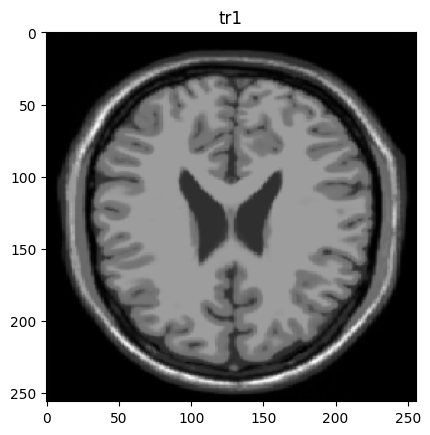

In [12]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

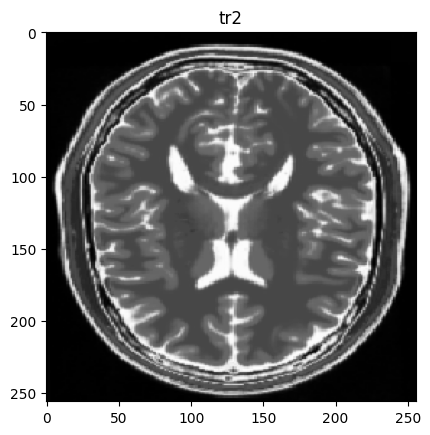

In [13]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

### Model Building
1. Instance Normalization
2. Downsampling, Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

#### Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

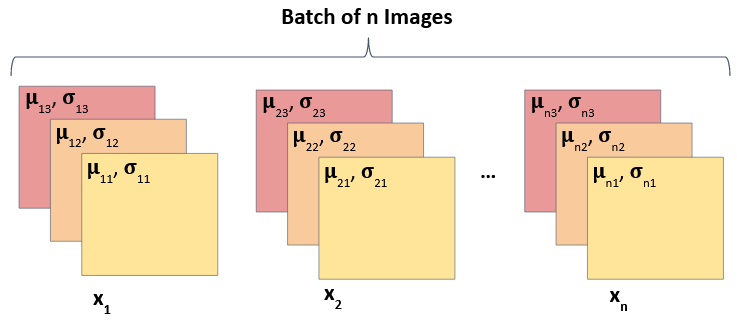

In [14]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling
Downsampling is performed using the Convolution, leading to reduce in dimensions.

In [15]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result



#### Upsampling
Upsampling is a result of Transposed Convolution, where dimension of image are increased.

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

#### Unets
Unets takes Image as an input and translate it into another Image. <p>
To do this they first use Downsampling on Input Image to learn the latent characteristics of Input Image and then use Upsampling to use this knowledge to Translate it into another Image. <p>
Let's understand it through the below image.

<center>

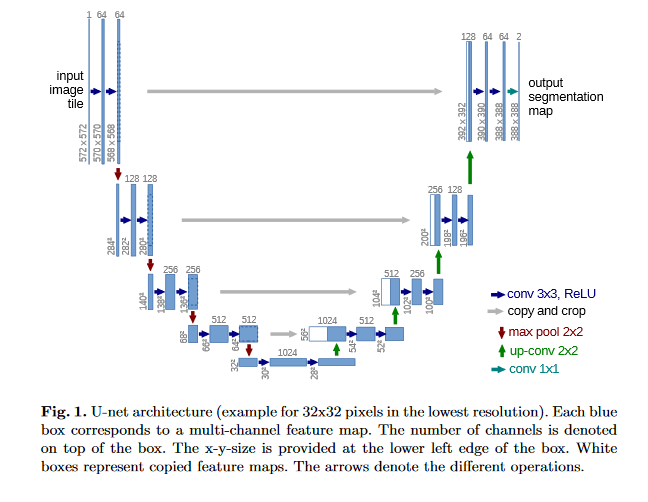

</center>

In [17]:
def unet_generator():

    down_stack = [
      downsample(64, 4, apply_norm=False),
      downsample(128, 4),
      downsample(256, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
    ]
                  #create a stack of downsample models
    up_stack = [
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4),
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4),
               ] #create a stack of upsample models

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh')
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Generator
Generator is a Unet Network here since We want to translate One type of Image (digit 4) into Another type of Image (digit 9).

In [18]:
generator_g = unet_generator()
generator_f = unet_generator()

Let's also visualize one of our Generator Models since Both our Generators have same architecture.

Notice How the dimension reduces first but then increases.

In [19]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, None, 64)       1024      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, None, None, 128)      131328    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, None, None, 256)      524800    ['sequential_1[0][0]']        
                                                                                              

#### Discriminator
Discriminator is a traditional CNN, which we use to classify the Images. It only uses Downsampling hence.

Both Discriminators have same architecture

In [20]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4,  False)(x)  #write your code to downsample X
    down2 = downsample(128, 4)(down1)     #write your code to downsample down1
    down3 = downsample(256, 4)(down2)     #write your code to downsample down2
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last) #create the model using input & output layer

In [21]:
discriminator_x = discriminator()
discriminator_y = discriminator()

Have a look at Discriminator's architecture, Notice that The Dimensions are reducing overall at the end since it's a classifier and only Convolution layers are being used.

In [22]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 1)]   0         
                                                                 
 sequential_30 (Sequential)  (None, None, None, 64)    1024      
                                                                 
 sequential_31 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_32 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d (ZeroPaddin  (None, None, None, 256)   0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

### Model Training
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

Check output of Untrained Generator models which should be a random noise

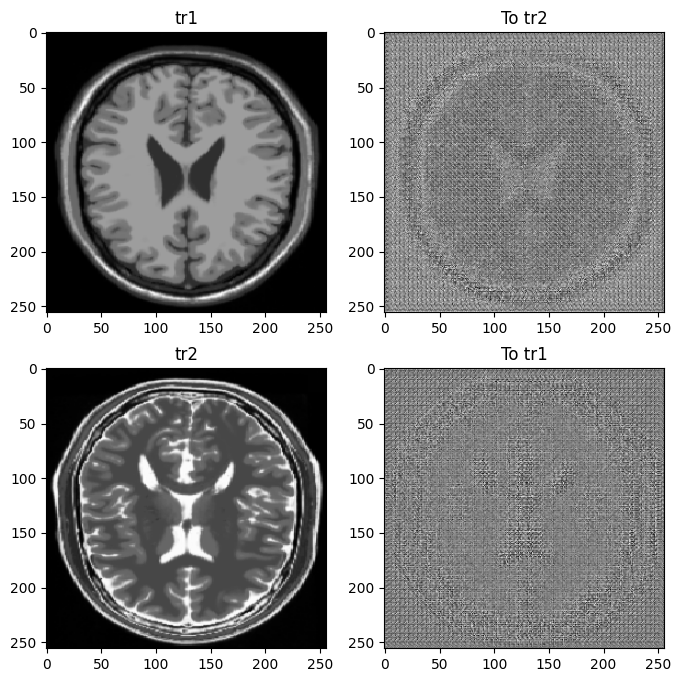

In [23]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

#### Declare Loss as Binary Cross Entropy
Since Our Discriminator is a classifier

In [24]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

In [25]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

In [26]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

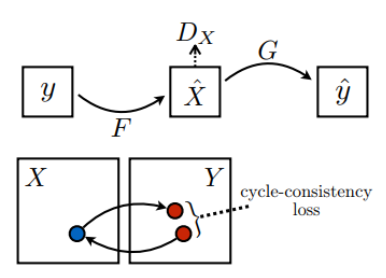

In [27]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### Identity Loss
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

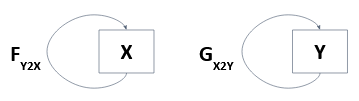

In [28]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

#### Optimizer
We use Adam Optimizer to update weights which is a good optimizer to achieve quick learning.

In [29]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

We'll train out Model for 50 Epochs

In [30]:
EPOCHS = 50

#### Checkpoint Initialization
Initialize checkpoints to save models

In [31]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Function to show Images output by Generators while Training

In [32]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

#### Training FLow
Below Function performs one Flow of Batch Training <p>
Notice that Identity Loss and Cycle Loss are only used in training Generator and not Discriminator

Sequence of Training Flow


1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.



In [33]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#### Train the CycleGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generators are getting better at producing realistic images epoch by epoch

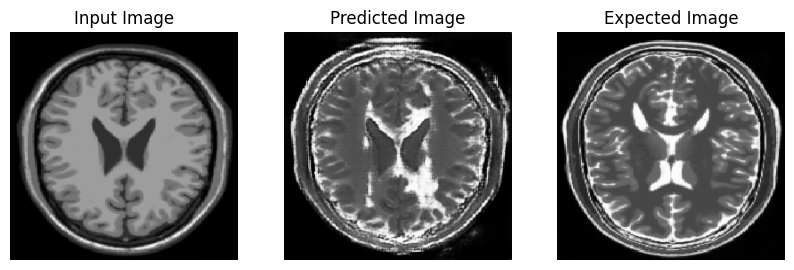

Saving checkpoint for epoch 11 at ./Trained_Model/ckpt-483


In [ ]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
        generate_images(generator_g, sample_tr1, sample_tr2)
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [ ]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    generate_images(generator_g, inp, sample_tr2)

### Generating a GIF for visualization of Results
Notice the Quality of results we are getting.

In [ ]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)